# Finding Dratini

<img src="http://cdn.bulbagarden.net/upload/c/cc/147Dratini.png" width="180" height="100" style="float:left"/> 

In this exercise we explore the relationship between Pokemon co-occurrence information and Dratini spawns. We will predict where Dratini is likely to appear using logistic regression and an SVM. 

In [26]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits
import heapq
from mpl_toolkits.basemap import Basemap
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
from sklearn import svm

Let's read in the data and check out the preview. 

In [27]:
SF = pd.read_csv('dratini_here.csv').drop(["Unnamed: 0"],1)
SF.head()

,num,lat,lng,distance,1,10,100,101,102,103,...,91,92,93,94,95,96,97,98,99,dratini_here
0,98,37.736643,-122.177133,0.000000,1,4,0,0,2,0,...,0,1,0,0,0,0,0,3,0,0
1,13,37.736698,-122.172787,0.382338,1,4,0,0,1,0,...,0,1,0,0,0,0,0,5,0,0
2,32,37.733748,-122.173408,0.459418,1,4,0,0,2,0,...,0,1,0,0,0,0,0,4,0,0
3,21,37.741257,-122.178641,0.530117,2,5,0,0,1,0,...,0,1,0,0,0,0,0,5,0,0
4,118,37.732741,-122.181124,0.558203,1,4,0,0,2,0,...,0,1,0,0,0,0,0,4,0,0


We have a list of Pokemon spawns in the San Francisco area. Each row tells us the Pokemon that spawned (given by its Pokemon number), the location and the distance from an arbitrary starting point. The next columns tell us about the co-occurrence information with other Pokemon. All Pokemon that ever spawned within 2km of this location are recorded in the co-occurrence columns labelled by Pokemon number. The final column tells us whether or not Dratini ever spawned within 2km of this location (1 for yes, 0 for no). In this exercise, we will use only the co-occurrence information to predict the Dratini zones. To be fair, we also drop the Dratini information (column "147").

In [28]:
spawns = SF.drop(["num","lat","lng","distance","147"],1)

In [29]:
spawns.head()

,1,10,100,101,102,103,104,105,106,107,...,91,92,93,94,95,96,97,98,99,dratini_here
0,1,4,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,0,3,0,0
1,1,4,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,5,0,0
2,1,4,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,0,4,0,0
3,2,5,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,5,0,0
4,1,4,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,0,4,0,0


Before applying any learning algorithms, let's explore the data a bit. Which Pokemon might we expect to be indicators of Dratini? Let's find the most common Pokemon in the Dratini zones, normalized by their overall appearance.

In [30]:
percentage_appearance =  (spawns[spawns['dratini_here'] == 1].sum(axis=0) / spawns.sum(axis = 0))
percentage_appearance = percentage_appearance[~np.isnan(percentage_appearance)].drop(["dratini_here"])

In [31]:
percentage_appearance.sort_values(ascending=False).head()

80    0.900000
88    0.850394
44    0.672956
12    0.666667
70    0.657210
dtype: float64

<img src="http://cdn.bulbagarden.net/upload/2/2a/044Gloom.png" width="180" height="100" style="float:left"/> 
<img src="http://cdn.bulbagarden.net/upload/9/9f/070Weepinbell.png" width="180" height="100" style="float:left"/> 
<img src="http://cdn.bulbagarden.net/upload/8/80/080Slowbro.png" width="180" height="100" style="float:left"/> 
<img src="http://cdn.bulbagarden.net/upload/d/d1/012Butterfree.png" width="180" height="100" style="float:left"/> 
<img src="http://cdn.bulbagarden.net/upload/a/a0/088Grimer.png" width="180" height="100" style="float:left"/>     

The left column gives the Pokemon number, while the right column gives the percentage of that Pokemon's appearances which were in a Dratini zone. The 5 most common pokemon in the Dratini zones are 80: Slowbro, 88: Grimer, 44: Gloom, 12: Butterfree, and 70: Weepinbell. Later we can check if these turn out to be important to our prediction function.

First let's split our data into the training, cross-validation, and test sets at a 60/20/20 split:

In [32]:
train =SF.sample(frac=0.6)
rest = SF.drop(train.index)
cross = rest.sample(frac=0.5)
test = rest.drop(cross.index)
print len(train),len(cross),len(test)

6000 2000 2000


And further into the features (co-occurrence information) and the labels (dratini_here value):

In [33]:
X_all = SF.drop(["num","lat","lng","distance","dratini_here","147"],1)
y_all = SF.dratini_here
X_train = train.drop(["num","lat","lng","distance","dratini_here","147"],1)
y_train = train.dratini_here
X_cross = cross.drop(["num","lat","lng","distance","dratini_here","147"],1)
y_cross = cross.dratini_here
X_test = test.drop(["num","lat","lng","distance","dratini_here","147"],1)
y_test = test.dratini_here

First let's try logistic regression using [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). We can test out a few values of the regularization constant $C$ and select the best model. 

In [34]:
#a function to perform logistic regression given the solver and list of C values to try
#return a table of (train score, cv score) for each value of C

def LRcompare(solver,C,X_train,y_train,X_cross,y_cross):
    compare_table = pd.DataFrame(index=[solver], columns=C)
    for index, row in compare_table.iterrows():
        for C_value in C:
            compare_table[C_value].loc[index] = compute_scores(solver,C_value,X_train,y_train,X_cross,y_cross)
    
    return compare_table

def compute_scores(solver_choice,C_value,X_train,y_train,X_cross,y_cross):
    model = LogisticRegression(solver = solver_choice, C = C_value)
    model.fit(X_train,y_train)
    train_score = model.score(X_train,y_train)
    cv_score = model.score(X_cross,y_cross)
    
    return (train_score,cv_score)

We will use the *liblinear* solver and feed in the $C$ values we want to test. Smaller values correspond to stronger regularization. 

In [35]:
C = [.001,.01,.1,.5,1,2,10,100,1000]
solver = "liblinear" #try different ones 
LR = LRcompare(solver,C,X_train,y_train,X_cross,y_cross)

In [36]:
LR

,0.001,0.01,0.1,0.5,1.0,2.0,10.0,100.0,1000.0
liblinear,"(0.906833333333, 0.9115)","(0.930166666667, 0.9345)","(0.943666666667, 0.9525)","(0.946, 0.952)","(0.948, 0.953)","(0.9495, 0.954)","(0.951833333333, 0.9535)","(0.952333333333, 0.9535)","(0.9525, 0.9535)"


For each value of $C$ we can look up the model score given on the (training set, cross-validation set). In this case, $C=2$ is giving the best performance on the cross-validation set at a mean accuracy of 95.4%, so this is the model we will choose. Notice how the score on the training set continues to increase as $C$ increases, but the score on the cross-validation set begins to decrease after $C=2$. This indicates that the model is overfitting due to weak regularization in this regime.

Let's look at our best model a little more closely. 

In [37]:
model = LogisticRegression(C=2)
model.fit(X_all,y_all)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We can extract the weights of the features:

In [39]:
coeffs = model.coef_[0]

And check the values and location of the largest weights:

In [40]:
heapq.nlargest(5,coeffs)

[4.0117378029489279,
 3.5113036749872553,
 2.9869836337473421,
 2.879167149700403,
 2.8236749151051677]

In [41]:
coeffs.argsort()[-5:][::-1]

array([128,  23,  88,  79, 117])

And finally let's check which Pokemon numbers these weights correspond to:

In [42]:
print list(X_all)[128], list(X_all)[23], list(X_all)[79], list(X_all)[88], list(X_all)[117] 

80 12 36 44 70


These are Slowbro, Butterfree, Clefable, Gloom, and Weepinbell.  
Since we're using a linear classifier, we can loosely interpret the largest weights as those which are important to the prediction function. We see here that our intuition about which Pokemon frequently spawn in Dratini zones turned out to be useful for classification.

Next let's try to improve our model performance by using [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.get_params). Again we can test out different regularization strengths, and this time we can test out different kernels. 

In [43]:
#a function to perform an SVM learning algorithm given a list of kernels and C values to try
#return a table of (train score, cv score) for each value of C and each kernel

def SVMcompare(kernels,C,X_train,y_train,X_cross,y_cross):
    compare_table = pd.DataFrame(index=kernels, columns=C)
    for index, row in compare_table.iterrows():
        for C_value in C:
            compare_table[C_value].loc[index] = compute_scores_SVM(index,C_value,X_train,y_train,X_cross,y_cross)
    
    return compare_table

def compute_scores_SVM(kernel_choice,C_value,X_train,y_train,X_cross,y_cross):
    model = svm.SVC(kernel = kernel_choice, C = C_value)
    model.fit(X_train,y_train)
    train_score = model.score(X_train,y_train)
    cv_score = model.score(X_cross,y_cross)
    
    return (train_score,cv_score)

We will test 4 of the available kernels, but it's also possible to write your own. 

In [44]:
kernels = ["linear","poly","rbf","sigmoid"]  
SVM = SVMcompare(kernels,C,X_train,y_train,X_cross,y_cross) 

In [45]:
SVM

,0.001,0.01,0.1,0.5,1.0,2.0,10.0,100.0,1000.0
linear,"(0.925833333333, 0.936)","(0.940833333333, 0.949)","(0.947833333333, 0.952)","(0.954, 0.955)","(0.956833333333, 0.9515)","(0.956666666667, 0.952)","(0.956666666667, 0.9505)","(0.957833333333, 0.9505)","(0.957666666667, 0.9495)"
poly,"(0.931166666667, 0.9365)","(0.947166666667, 0.9495)","(0.966666666667, 0.965)","(0.978166666667, 0.97)","(0.986, 0.971)","(0.99, 0.9735)","(0.995833333333, 0.9715)","(0.998166666667, 0.972)","(0.999333333333, 0.9655)"
rbf,"(0.869333333333, 0.8735)","(0.869333333333, 0.8735)","(0.933, 0.9305)","(0.968833333333, 0.964)","(0.979, 0.972)","(0.987166666667, 0.9755)","(0.997166666667, 0.981)","(0.999666666667, 0.9805)","(0.999833333333, 0.98)"
sigmoid,"(0.869333333333, 0.8735)","(0.869333333333, 0.8735)","(0.795666666667, 0.7875)","(0.769166666667, 0.764)","(0.766166666667, 0.762)","(0.764666666667, 0.761)","(0.763, 0.76)","(0.762833333333, 0.76)","(0.762666666667, 0.76)"


Again we select the model based on the highest mean accuracy on the cross-validation set. In this case, we should choose $C=10$ with an "rbf" kernel. 

In [46]:
#use the best model 
model = svm.SVC(kernel = "rbf", C = 10)
model.fit(X_train,y_train)
train_score = model.score(X_train,y_train)
cv_score = model.score(X_cross,y_cross)
test_score = model.score(X_test,y_test)

Because we used the cross-validation set for model selection, we should now report our final mean accuracy on the test set which has remained independent of both the learned parameters and the model. 

In [48]:
test_score

0.98150000000000004

We have achieved a mean accuracy of 98.15% when predicting the Dratini zones. 

Finally, let's plot a heat map of where to find Dratini based on the predictions of our model. 

In [49]:
map_info = SF[['lat','lng']]
scores_all = model.decision_function(X_all)
map_info = map_info.assign(scores=scores_all)
map_info.head()

,lat,lng,scores
0,37.736643,-122.177133,-1.669948
1,37.736698,-122.172787,-1.660803
2,37.733748,-122.173408,-1.414577
3,37.741257,-122.178641,-1.186113
4,37.732741,-122.181124,-1.819549


For each latitude and longitude, we feed the co-occurance information of that location to the model which outputs a score using the [decision_function](http://scikit-learn.org/stable/modules/svm.html#scores-probabilities) method. The score is the distance of that point from the seperating hyperplane (predict 1 if score > 0), so it gives us a relative measure of how certain the model is of that prediction. We will use the score information to fill in the colour of each point on the map.    

Basemap is a nice tool for drawing maps, and you can find a good tutorial [here](http://introtopython.org/visualization_earthquakes.html). 

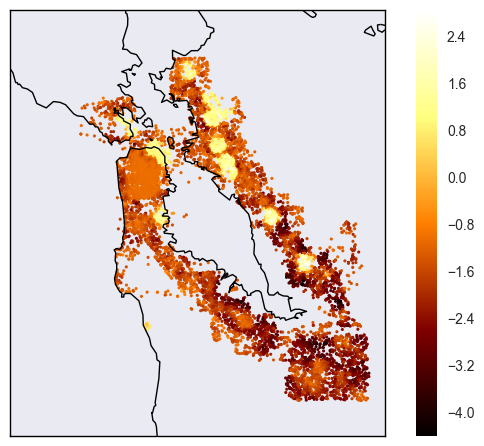

In [53]:
map = Basemap(projection='merc', lat_0 = 37.6, lon_0 = -122.5,
    resolution = 'h', area_thresh = 0.05,
    llcrnrlon=-122.8, llcrnrlat=37.2,
    urcrnrlon=-121.8, urcrnrlat=38.1)
 
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()

lons = map_info['lng'].tolist()
lats = map_info['lat'].tolist()
vals = map_info['scores'].tolist()
x,y = map(lons, lats)

map.scatter(x,y,c=vals,marker=".",cmap='afmhot', lw =0)
plt.colorbar() 
plt.show()

The yellow pockets are where we're likely to find Dratini!

In this exercise, we saw that the occurrence of a certain Pokemon can successfully be predicted using the co-occurrence information of other Pokemon. The features were created by asking how many times each Pokemon occured within 2Km of each location. Could we improve the features by moving away from a binary interpretation (either within 2Km or not)? For example, we could assign a score to each occurrence based on how far away it was. Similarly, we could replace the dratini_here values with a continuous variable (distance to nearest Dratini spawn for example). What other modifications to our features might improve predictive power?  